# Make moons

In [1]:
import math
import copy
import pickle
import numpy as np
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
device = torch.device('mps')
seed = 1
np.random.seed(seed)

In [3]:
def load_datasets(filename="dataset.pkl"):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data["datasets"], data["time_points"]

datasets, time_points = load_datasets('dataset.pkl')

In [4]:
data_subsets = []

# Iterate through the original datasets and their index
for idx, (X_t, y_t) in enumerate(datasets):
    # Create a dictionary for the current domain
    domain_data = {
        'idx': idx,                             # Domain index (e.g., 0, 1, 2)
        'X_data': X_t,                          # The data points (e.g., NumPy array or tensor)
        'y_labels': y_t,                        # The corresponding categories/labels
        'time': time_points[idx],               # The associated time point for this domain
        'domain_name': f"Domain {idx+1}"        # A descriptive name
    }
    
    # Add the organized subset to the main list
    data_subsets.append(domain_data)

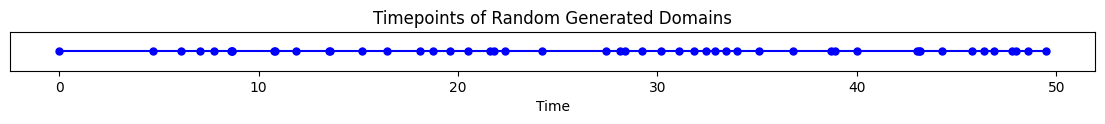

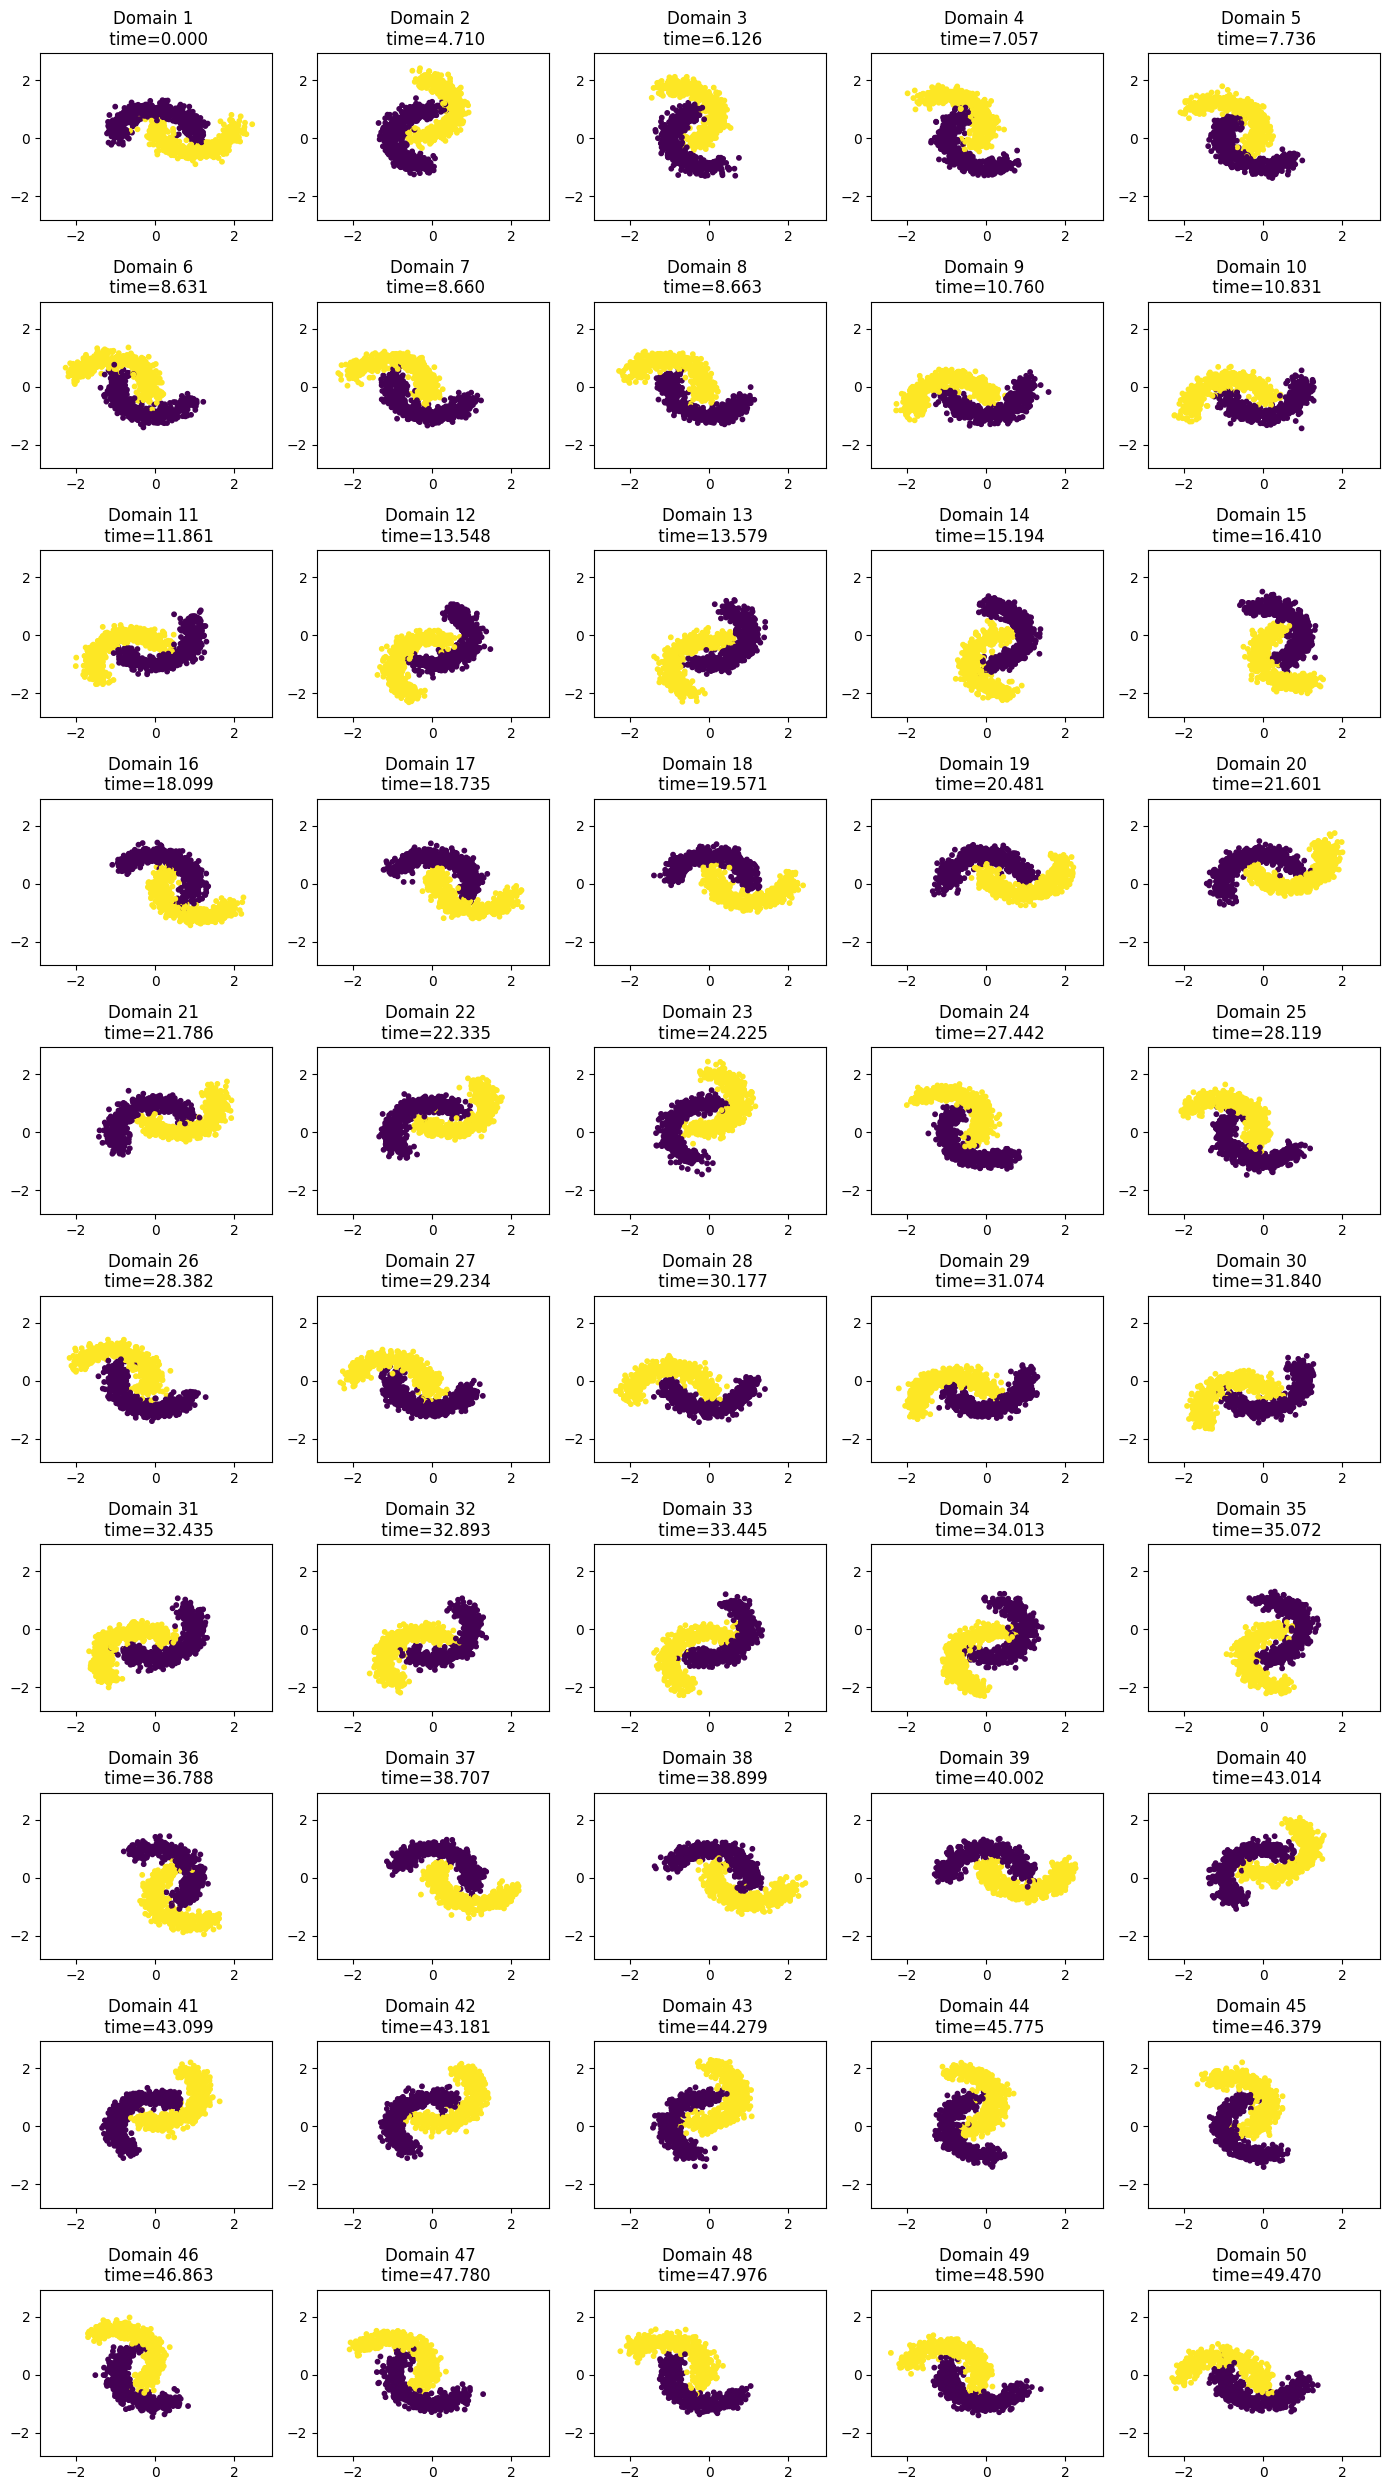

In [5]:
def visualize_moon(datasets, time_points):
    ndomamins = len(time_points)
    ncols = 5
    nrows = math.ceil(ndomamins / ncols)
    
    fig, axs = plt.subplots(figsize=(14, 2.5 * nrows), nrows=nrows, ncols=ncols)
    axs = axs.ravel()

    all_data = np.vstack([data for data, _ in datasets])
    x_min, x_max = all_data[:, 0].min() - 0.5, all_data[:, 0].max() + 0.5
    y_min, y_max = all_data[:, 1].min() - 0.5, all_data[:, 1].max() + 0.5

    for idx, (X_t, y_t) in enumerate(datasets):
        axs[idx].scatter(X_t[:, 0], X_t[:, 1], s=10, c=y_t)
        axs[idx].set_xlim([x_min, x_max])
        axs[idx].set_ylim([y_min, y_max])
        axs[idx].set_title(f"Domain {idx+1} \n time={time_points[idx]:.3f}")
    plt.tight_layout()
    plt.show()
    
def visualize_time(time_points):
    plt.figure(figsize=(14, 0.5))
    plt.plot(time_points, np.zeros_like(time_points), 'bo-', label="Domains", markersize=5)
    plt.yticks([])
    
    plt.xlabel("Time")
    plt.title("Timepoints of Random Generated Domains")
    plt.show()

visualize_time(time_points)            # visualize moments of randomly selected domains
visualize_moon(datasets, time_points)  # visualize each domain


In [7]:
import numpy as np
from pykalman import KalmanFilter

In [18]:
# The centroid measurements and time points from all domains #[d['X_data'].mean(axis=0)
all_measurements = np.array(
    [d['X_data'].mean(axis=0) for d in data_subsets]
)
all_times = np.array([d['time'] for d in data_subsets])


print(f"Training on {len(measurements_train)} samples (indices 0-{train_idx-1}).")
print(f"Testing on 1 sample (index {train_idx}).\n")

Training on 46 samples (indices 0-45).
Testing on 1 sample (index 46).



In [19]:
from sklearn.decomposition import PCA
# --- NEW: Get rotation measurements using PCA ---
def get_orientation(data):
    """Calculates the orientation angle of the point cloud using PCA."""
    # 1. Center the data
    centered_data = data - data.mean(axis=0)
    # 2. Fit PCA
    pca = PCA(n_components=2).fit(centered_data)
    # 3. Get the first principal component vector
    pc1 = pca.components_[0]
    # 4. Calculate the angle
    angle = np.arctan2(pc1[1], pc1[0])
    return angle

# We need to unwrap angles to avoid 359 -> 0 degree jumps
all_theta_measurements_raw = np.array([get_orientation(d['X_data']) for d in data_subsets])
all_theta_measurements = np.unwrap(all_theta_measurements_raw) # Crucial step!

print("Data pre-processing complete.")

Data pre-processing complete.


In [20]:
# --- 3. Split Data ---
train_idx = 46
# Centroid data
measurements_train = all_measurements[:train_idx]
measurement_test = all_measurements[train_idx]
# Rotation data
theta_train = all_theta_measurements[:train_idx]
theta_test = all_theta_measurements[train_idx]
# Time data
times_train = all_times[:train_idx]
time_test = all_times[train_idx]
last_train_time = times_train[-1]

dts_train = np.diff(times_train)
dt_for_prediction = time_test - last_train_time

In [14]:
# --- 4. KF #1: TRANSLATION (Centroid) ---
print("\nTraining KF #1 (Translation)...")
n_dim_state_pos = 4
n_dim_obs_pos = 2

# Create list of transition matrices
transition_matrices_list_pos = []
for dt in dts_train:
    F_pos = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
    transition_matrices_list_pos.append(F_pos)
transition_matrices_list_pos = np.array(transition_matrices_list_pos)

kf_pos = KalmanFilter(
    n_dim_state=n_dim_state_pos,
    n_dim_obs=n_dim_obs_pos,
    transition_matrices=transition_matrices_list_pos,
    observation_matrices=np.array([[1, 0, 0, 0], [0, 1, 0, 0]]),
    transition_covariance=np.eye(n_dim_state_pos) * 0.1,
    observation_covariance=np.eye(n_dim_obs_pos) * 0.1,
    initial_state_mean=np.array([measurements_train[0, 0], measurements_train[0, 1], 0, 0])
)
kf_pos = kf_pos.em(measurements_train, n_iter=5)
(filtered_state_means_pos, _) = kf_pos.filter(measurements_train)


Training KF #1 (Translation)...


In [15]:
# --- 5. KF #2: ROTATION (Angle) ---
print("Training KF #2 (Rotation)...")
n_dim_state_rot = 2 # [theta, omega]
n_dim_obs_rot = 1   # [theta]

# Create list of transition matrices
transition_matrices_list_rot = []
for dt in dts_train:
    F_rot = np.array([[1, dt], [0, 1]]) # State transition for [theta, omega]
    transition_matrices_list_rot.append(F_rot)
transition_matrices_list_rot = np.array(transition_matrices_list_rot)

kf_rot = KalmanFilter(
    n_dim_state=n_dim_state_rot,
    n_dim_obs=n_dim_obs_rot,
    transition_matrices=transition_matrices_list_rot,
    observation_matrices=np.array([[1, 0]]), # We only observe theta
    transition_covariance=np.eye(n_dim_state_rot) * 0.1,
    observation_covariance=np.eye(n_dim_obs_rot) * 0.01,
    initial_state_mean=np.array([theta_train[0], 0]) # Initial theta, initial omega=0
)
kf_rot = kf_rot.em(theta_train.reshape(-1, 1), n_iter=5) # Must be (n, 1) shape
(filtered_state_means_rot, _) = kf_rot.filter(theta_train.reshape(-1, 1))

Training KF #2 (Rotation)...


In [16]:
# --- 6. PREDICT for t=n+1 (Both KFs) ---

# --- KF #1 (Translation) Prediction ---
state_at_n_mean_pos = filtered_state_means_pos[-1]
F_next_pos = np.array([[1, 0, dt_for_prediction, 0], [0, 1, 0, dt_for_prediction], [0, 0, 1, 0], [0, 0, 0, 1]])
predicted_state_at_n_plus_1_pos = np.dot(F_next_pos, state_at_n_mean_pos)
predicted_center = np.dot(kf_pos.observation_matrices, predicted_state_at_n_plus_1_pos)

print("\n--- 🎯 Centroid Prediction ---")
print(f"Actual Centroid: \n{measurement_test}\n")
print(f"Predicted Centroid: \n{predicted_center}\n")
print(f"Error (Distance): {np.linalg.norm(predicted_center - measurement_test):.4f}")

# --- KF #2 (Rotation) Prediction ---
state_at_n_mean_rot = filtered_state_means_rot[-1]
F_next_rot = np.array([[1, dt_for_prediction], [0, 1]])
predicted_state_at_n_plus_1_rot = np.dot(F_next_rot, state_at_n_mean_rot)
predicted_theta = predicted_state_at_n_plus_1_rot[0] # The predicted angle
last_known_theta = theta_train[-1]

print("\n--- 🎯 Rotation Prediction ---")
print(f"Actual Angle (rad): \n{theta_test:.4f}\n")
print(f"Predicted Angle (rad): \n{predicted_theta:.4f}\n")
print(f"Error (Radians): {abs(predicted_theta - theta_test):.4f}")


--- 🎯 Centroid Prediction ---
Actual Centroid: 
[-0.5400422   0.13481305]

Predicted Centroid: 
[-0.61069904  0.18826017]

Error (Distance): 0.0886

--- 🎯 Rotation Prediction ---
Actual Angle (rad): 
2.1132

Predicted Angle (rad): 
2.1103

Error (Radians): 0.0029



Generating prediction cloud plot...


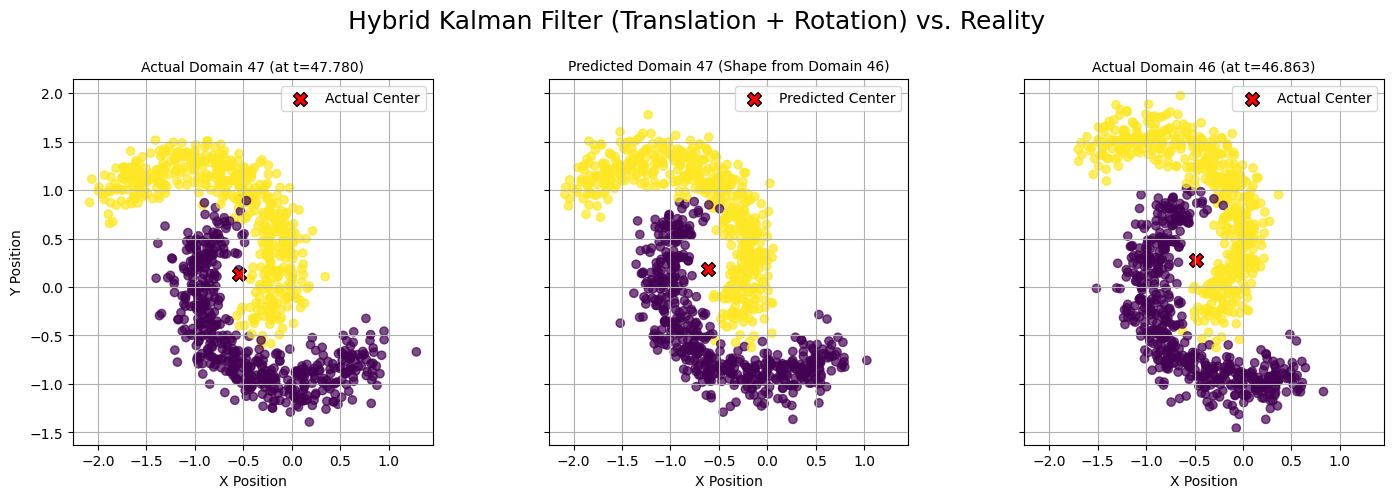

In [17]:
# --- 7. Plot Predicted Cloud vs. Actual Cloud ---

# Get last known cloud data (Domain 46)
last_known_cloud = data_subsets[train_idx - 1]['X_data']
last_known_labels = data_subsets[train_idx - 1]['y_labels']
last_known_center = measurements_train[-1]

# Get actual cloud data (Domain 47)
actual_cloud = data_subsets[train_idx]['X_data']
actual_labels = data_subsets[train_idx]['y_labels']
actual_center = measurement_test

# --- NEW: Cloud Prediction using Rotation + Translation ---
# 1. Get cloud relative to its old center
relative_cloud = last_known_cloud - last_known_center
# 2. Calculate the *change* in angle to apply
delta_theta = predicted_theta - last_known_theta
R_pred = np.array([
    [np.cos(delta_theta), -np.sin(delta_theta)],
    [np.sin(delta_theta), np.cos(delta_theta)]
])
# 3. Apply rotation
rotated_cloud = relative_cloud.dot(R_pred.T)
# 4. Apply translation to the *new* predicted center
predicted_cloud = rotated_cloud + predicted_center
# --- End of new prediction logic ---

print("\nGenerating prediction cloud plot...")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Subplot 1: The REAL Data of 47
ax1.scatter(actual_cloud[:, 0], actual_cloud[:, 1], c=actual_labels, alpha=0.7)
ax1.scatter(actual_center[0], actual_center[1], c='red', s=100, marker='X', label='Actual Center', edgecolors='k')
ax1.set_title(f"Actual Domain 47 (at t={time_test:.3f})", fontsize=10)
ax1.set_xlabel("X Position")
ax1.set_ylabel("Y Position")
ax1.legend()
ax1.grid(True)
ax1.set_aspect('equal', adjustable='box')

# Subplot 2: The PREDICTED Data of 47
ax2.scatter(predicted_cloud[:, 0], predicted_cloud[:, 1], c=last_known_labels, alpha=0.7)
ax2.scatter(predicted_center[0], predicted_center[1], c='red', s=100, marker='X', label='Predicted Center', edgecolors='k')
ax2.set_title(f"Predicted Domain 47 (Shape from Domain 46)", fontsize=10)
ax2.set_xlabel("X Position")
ax2.legend()
ax2.grid(True)
ax2.set_aspect('equal', adjustable='box')

# Subplot 3: The Real Data of 46
ax3.scatter(last_known_cloud[:, 0], last_known_cloud[:, 1], c=last_known_labels, alpha=0.7)
ax3.scatter(last_known_center[0], last_known_center[1], c='red', s=100, marker='X', label='Actual Center', edgecolors='k')
ax3.set_title(f"Actual Domain 46 (at t={times_train[-1]:.3f})", fontsize=10)
ax3.set_xlabel("X Position")
ax3.legend()
ax3.grid(True)
ax3.set_aspect('equal', adjustable='box')

plt.suptitle("Hybrid Kalman Filter (Translation + Rotation) vs. Reality", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()